In [44]:
import pandas as pd
import plotly.express as px
import aqi as aqi
import matplotlib.pyplot as plt
import ruptures as rpt

In [93]:
# read in data
data_file = "waqi-covid19-airqualitydata-2020.csv"
df_2020 = pd.read_csv(data_file)

df_2019Q4 = pd.read_csv("waqi-covid19-airqualitydata-2019Q4.csv")
df_2019Q3 = pd.read_csv("waqi-covid19-airqualitydata-2019Q3.csv")
df_2019Q2 = pd.read_csv("waqi-covid19-airqualitydata-2019Q2.csv")
df_2019Q1 = pd.read_csv("waqi-covid19-airqualitydata-2019Q1.csv")

df_2019_1 = df_2019Q4.append(df_2019Q3)
df_2019_2 = df_2019_1.append(df_2019Q2)
df_2019 = df_2019_2.append(df_2019Q1)

df_2020['Date'] = df_2020['Date'].astype('datetime64[ns]')
df_2019['Date'] = df_2019['Date'].astype('datetime64[ns]')

bad_species = ['wind gust', 'temperature', 'wind speed', 'wind-gust', 'pressure', 'dew', 'wind-speed',
       'humidity', 'precipitation', 'wd', 'uvi']
good_species = ['pm25', 'pm10', 'no2', 'o3', 'so2', 'co']

# df_2020 = df_2020[~df_2020.Specie.isin(bad_species)]
# df_2019 = df_2019[~df_2019.Specie.isin(bad_species)]

df_2020 = df_2020[df_2020.Specie.isin(good_species)]
df_2019 = df_2019[df_2019.Specie.isin(good_species)]

df_combined = df_2020.append(df_2019)

# Change Point

In [89]:
df_test = df_combined[(df_combined['City']=='Beijing') & (df_combined['Specie'] == 'no2')].sort_values(by=['Date'])

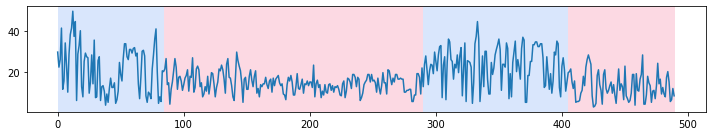

In [72]:
signal = df_test['median'].to_numpy()

algo = rpt.Pelt(model="rbf").fit(signal)
result = algo.predict(pen=10)

# display
rpt.display(signal, result, [0])
plt.show()

In [73]:
result

[85, 290, 405, 490]

In [74]:
df_test.shape

(490, 10)

In [76]:
df_test.reset_index(drop=True).iloc[result[:-1],]

,City,Country,Date,Specie,Unnamed: 0,count,max,median,min,variance
85,Beijing,CN,2019-03-26,no2,NaN,438,57.3,21.5,3.2,994.65
290,Beijing,CN,2019-10-10,no2,NaN,460,39.4,12.8,1.0,506.14
405,Beijing,CN,2020-01-26,no2,303092.0,472,46.7,19.7,6.4,558.98


# AQI

In [107]:
df = df_combined

In [108]:
df.shape

(1292483, 10)

In [105]:
# for purpose of using aqi package
d = {}
d['pm25'] = aqi.POLLUTANT_PM25
d['pm10'] = aqi.POLLUTANT_PM10
d['no2'] = aqi.POLLUTANT_NO2_1H
d['o3'] = aqi.POLLUTANT_O3_8H
d['so2'] = aqi.POLLUTANT_SO2_1H
d['co'] = aqi.POLLUTANT_CO_8H

# df = df.drop(df[(df['Specie'] == 'co') & (df['median'] == 58.0)].index)

In [106]:
df.shape

(1292434, 10)

In [110]:
??aqi.ALGO_EPA

In [109]:
def compute_iaqi(row):
    if(row['Specie'] == 'o3'):
        row['median']/= 1000
    return aqi.to_iaqi(d[row['Specie']], row['median'], algo=aqi.ALGO_EPA)
df['iaqi'] = df.apply(compute_iaqi,axis=1)

IndexError: ('list index out of range', 'occurred at index 72064')

In [86]:
df.iloc[26292]

City                      Piteşti
Country                        RO
Date          2020-02-10 00:00:00
Specie                        so2
Unnamed: 0                  54617
count                         116
max                          19.8
median                        4.1
min                           0.4
variance                   137.64
Name: 54617, dtype: object

In [ ]:
# take max to get final AQI 
df.sort_values(by=['City','Date'])

df_new = df.drop(['Country','Specie','count','min','max','median','variance'], axis = 1)
df_new = df_new.groupby(['Date','City']).max()

print(type(df_new.axes[1]))
def AQI(row):
    #print(df_new.loc[(row['Date'],row['City'])]["iaqi"])
    return df_new.loc[(row['Date'],row['City'])]["iaqi"]

df['AQI'] = df.apply(AQI,axis=1)

In [ ]:
df = df.sort_values(by=['City','Date'])
print(df['City'].unique())

In [ ]:
### City -> County 

d_tocounty = {}
d_tocounty['Albuquerque'] = 'Bernalillo'
d_tocounty['Atlanta'] = 'Fulton'

In [ ]:
# COVID data: confirmed 
df_confirmed = pd.read_csv("time_series_covid19_confirmed_US.csv")
df_confirmed.head()

In [ ]:
df_confirmed = df_confirmed.drop(['UID','iso2','iso3','code3','FIPS'],axis=1)
df_confirmed = df_confirmed.dropna()